In [7]:
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.models.resnet import ResNet50_Weights
import lightning.pytorch as pl
from ultralytics import YOLO

from mymodels import Model_Wrapper, Preprocess
from myutils import View, sample_imgs_list, compare_ds

In [8]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [9]:
model = YOLO('yolov8s.pt', )  # get pretrained model
# model = Model_Wrapper(model, type='yolo')  # wrap model to use with lightning
# trainer = pl.Trainer(accelerator='auto', limit_test_batches=3)

In [10]:
PATH_TO_COCO = '/f_storage/datasets/coco/2017'
NUM_IMG_EVAL = 10000
prep = Preprocess(PATH_TO_COCO, (640, 640), dataset_type='coco', shuffle=False, batch_size=8)
preview_img_slice = slice(00000, 50000, 10000)
%matplotlib inline

In [11]:
prep.reset_trans()
coco = prep.get_dataset()

id, img, size = coco[1]
print(f'img_shape: {img.shape}')

img_shape: torch.Size([3, 640, 640])



5.4ms


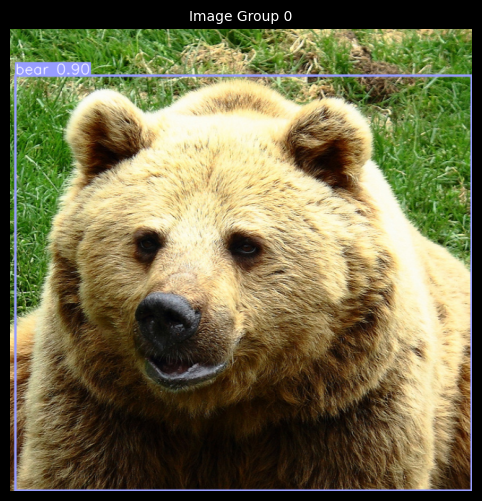

In [12]:
import numpy as np
from copy import deepcopy

results = model(img.unsqueeze(0)*255)

res_plot = deepcopy(results[0])
res_plot.orig_img = np.ascontiguousarray(img.permute(1, 2, 0).cpu().numpy() *255).astype(np.uint8)
plot = res_plot.plot()
View.compare_color(plot)

In [13]:
from coco_ds import CocoResults

# results[0].orig_shape = torch.Tensor(size)
# results[0].update()
# results[0].boxes.orig_shape = torch.Tensor(size)
# print(results[0].orig_shape)

print(results[0].boxes)

bboxes = results[0].boxes.xywh[0].cpu().tolist()
score = results[0].boxes[0].conf.cpu().item()
label = int(results[0].boxes[0].cls.cpu().item())

bboxes[0] *= size[1] / 640
bboxes[1] *= size[0] / 640
bboxes[2] *= size[1] / 640
bboxes[3] *= size[0] / 640

result = [label, bboxes, score]

print(result)

coco_results = CocoResults(coco).add_results([result], id)
# print(coco_results.coco_results)
mAP = coco_results.eval()
print(f'mAP: {mAP}')

ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[  7.8904,  64.6920, 639.0290, 639.2087,   0.8995,  21.0000]], device='cuda:0')
cls: tensor([21.], device='cuda:0')
conf: tensor([0.8995], device='cuda:0')
data: tensor([[  7.8904,  64.6920, 639.0290, 639.2087,   0.8995,  21.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: tensor([1, 3], device='cuda:0')
shape: torch.Size([1, 6])
xywh: tensor([[323.4597, 351.9504, 631.1386, 574.5167]], device='cuda:0')
xywhn: tensor([[107.8199, 351.9504, 210.3795, 574.5167]], device='cuda:0')
xyxy: tensor([[  7.8904,  64.6920, 639.0290, 639.2087]], device='cuda:0')
xyxyn: tensor([[  2.6301,  64.6920, 213.0097, 639.2087]], device='cuda:0')
[21, [323.4596862792969, 322.25456523895264, 631.1386108398438, 526.041875076294], 0.8995457887649536]
mAP: {'AP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'APs': -1.0, 'APm': -1.0, 'APl': 0.0, 'AR1': 0.0, 'AR10': 0.0, 'AR100': 0.0, 'ARs': -1.0, 'ARm': -1.0, 'ARl': 0.0}


In [14]:
# prep.reset_trans()
# imgnet_orig = prep.get_loader()
# sample_orig = sample_imgs_list(imgnet_orig, preview_img_slice)# test model on original images
# result_orig = trainer.test(model, imgnet_orig)